# Titanic Data Science Solutions

------------------------------------------------

This notebook is for "Titanic: Machine Learning from Disaster"

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score,roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
matplotlib.style.use('ggplot')

try:
    xrange
except NameError:
    xrange = range

from __future__ import print_function

In [5]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
all_df = [train_df, test_df]

## Show Sample Data

In [400]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [402]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


([array([  80.,   97.,  372.]), array([ 216.,  184.,  491.])],
 array([ 1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 2 Lists of Patches objects>)

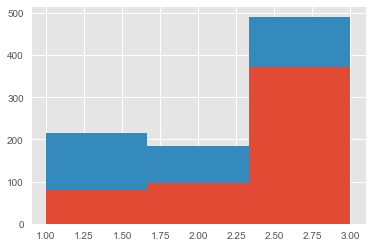

In [403]:
split_data = []
for survived in [0,1]:
    split_data.append(dataset[dataset.Survived==survived])

temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3)

([array([ 13.,  13.,   8.,  63.,  80.,  66.,  47.,  39.,  30.,  23.,  14.,
          11.,  10.,   3.,   4.,   0.]),
  array([  44.,   20.,   19.,   96.,  122.,  108.,   88.,   67.,   47.,
           39.,   24.,   18.,   14.,    3.,    4.,    1.])],
 array([  0.42   ,   5.39375,  10.3675 ,  15.34125,  20.315  ,  25.28875,
         30.2625 ,  35.23625,  40.21   ,  45.18375,  50.1575 ,  55.13125,
         60.105  ,  65.07875,  70.0525 ,  75.02625,  80.     ]),
 <a list of 2 Lists of Patches objects>)

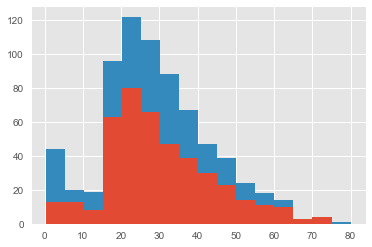

In [404]:
temp = [i["Age"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=16)

# How to check missing data

you need to fill in data if you find missing data

In [405]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Set Pclass as category data

In [406]:
df = pd.get_dummies(data=dataset, columns=["Pclass"])
df = pd.get_dummies(data=df, columns=["Embarked"])
df["Sex"] = LabelEncoder().fit_transform(df["Sex"])

In [407]:
df.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,1


In [408]:
df_dn = df.dropna()
df_dn = df_dn.drop('PassengerId',axis=1)
df_dn = df_dn.drop('Name',axis=1)
df_dn = df_dn.drop('Ticket',axis=1)
df_dn = df_dn.drop('Cabin',axis=1)
 
df_dn.corr()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.535727,-0.244604,0.100339,0.018723,0.134019,-0.003651,0.078889,-0.089709,0.098712,-0.039232,-0.104544
Sex,-0.535727,1.000000,0.172307,-0.095344,-0.081832,-0.129871,0.058139,-0.067462,-0.006463,-0.053879,-0.002826,0.076760
Age,-0.244604,0.172307,1.000000,-0.161625,-0.274813,-0.091542,0.310155,-0.200651,-0.226699,0.076824,0.017855,-0.099916
SibSp,0.100339,-0.095344,-0.161625,1.000000,0.258993,0.285492,0.086038,-0.027566,-0.096802,-0.050628,0.169778,0.029704
Parch,0.018723,-0.081832,-0.274813,0.258993,1.000000,0.388783,-0.026207,-0.027828,0.073213,-0.068949,-0.065543,0.096096
Fare,0.134019,-0.129871,-0.091542,0.285492,0.388783,1.000000,0.329997,-0.236345,-0.213612,0.239531,0.015604,-0.240180
Pclass_1,-0.003651,0.058139,0.310155,0.086038,-0.026207,0.329997,1.000000,-0.751469,-0.604743,0.224681,0.041324,-0.239473
Pclass_2,0.078889,-0.067462,-0.200651,-0.027566,-0.027828,-0.236345,-0.751469,1.000000,-0.071007,-0.135656,-0.031054,0.147197
Pclass_3,-0.089709,-0.006463,-0.226699,-0.096802,0.073213,-0.213612,-0.604743,-0.071007,1.000000,-0.175933,-0.024990,0.184364
Embarked_C,0.098712,-0.053879,0.076824,-0.050628,-0.068949,0.239531,0.224681,-0.135656,-0.175933,1.000000,-0.076941,-0.954268


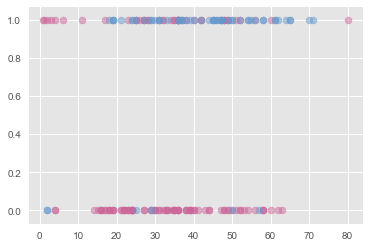

In [409]:
df_sur = df_dn[train_df_dn.Survived==1]
df_sur_age = df_sur.iloc[:,2]
df_sur_s = df_sur.iloc[:,1]
plt.scatter(df_sur_age, df_sur_s, color="#cc6699", alpha=0.5)

df_sur = df_dn[train_df_dn.Survived==0]
df_sur_age = df_sur.iloc[:,2]
df_sur_s = df_sur.iloc[:,1]
plt.scatter(df_sur_age, df_sur_s, color="#6699cc", alpha=0.5)

plt.show()

# Fill in nan blank

In [410]:
train_df = dataset.copy()

In [411]:
train_df[np.logical_and(train_df["Name"].str.contains("Mr"), ~train_df["Name"].str.contains("Mrs"))].Age.median()

30.0

In [412]:
train_df[train_df["Name"].str.contains("Mrs")].Age.median()

35.0

In [413]:
train_df[train_df["Name"].str.contains("Miss")].Age.median()

21.0

In [414]:
train_df[train_df["Name"].str.contains("Master")].Age.median()

3.5

In [415]:
for index, row in dataset.iterrows():
    if np.isnan(row["Age"]):
        if 'Miss' in row["Name"]:
            train_df.at[index, "Age"] = 21.0
        elif 'Mrs' in row["Name"]:
            train_df.at[index, "Age"] = 35.0
        elif 'Master' in row["Name"]:
            train_df.at[index, "Age"] = 3.5
        elif 'Mr' in row["Name"]:
            train_df.at[index, "Age"] = 30.0
        else:
            train_df.at[index, "Age"] = df.Age.median()

In [416]:
train_df["Embarked"].fillna('S', inplace=True)

In [417]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [418]:
train_df = pd.get_dummies(data=train_df, columns=["Pclass"])
train_df = pd.get_dummies(data=train_df, columns=["Embarked"])
train_df["Sex"] = LabelEncoder().fit_transform(train_df["Sex"])

# Add FamilySize as an attribute

In [419]:
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1

In [420]:
train_df.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,1,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0,2
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1,0,0,0,0,1,2
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,1,1


# Create Prediction Model by using Scikit Learn

In [421]:
target_col = "Survived"
exclude_cols = ["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Embarked"]
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

In [422]:
feature_cols

['Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'FamilySize']

In [423]:
y = np.array(train_df[target_col])
X = np.array(train_df[feature_cols])

In [424]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

# Select Model

In [425]:
rf = RandomForestClassifier(random_state=1234)
rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("RandomForest F-Score: ", f1)

RandomForest F-Score:  0.712871287129


# Variable Selection

In [426]:
max_imp = max(rf.feature_importances_)
for col, imp in sorted(zip(feature_cols, rf.feature_importances_), key = lambda x: x[1], reverse=True):
    print(col, "\t", round(imp/max_imp * 100, 2))

Age 	 100.0
Fare 	 95.9
Sex 	 66.07
Pclass_1 	 18.53
Pclass_3 	 14.5
FamilySize 	 14.14
Parch 	 12.14
SibSp 	 10.51
Pclass_2 	 6.57
Embarked_S 	 3.62
Embarked_C 	 3.26
Embarked_Q 	 2.81


# Create submission file

In [427]:
test_dataset = pd.read_csv("data/test.csv")

In [428]:
test_dataset.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [429]:
test_dataset.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [430]:
test_df = test_dataset.copy()

In [431]:
for index, row in test_df.iterrows():
    if np.isnan(row["Age"]):
        if 'Miss' in row["Name"]:
            test_df.at[index, "Age"] = 21.0
        elif 'Mrs' in row["Name"]:
            test_df.at[index, "Age"] = 35.0
        elif 'Master' in row["Name"]:
            test_df.at[index, "Age"] = 3.5
        elif 'Mr' in row["Name"]:
            test_df.at[index, "Age"] = 30.0
        else:
            test_df.at[index, "Age"] = df.Age.median()
test_df["Fare"].fillna(test_df.Fare.median(), inplace=True)

In [432]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [433]:
test_df = pd.get_dummies(data=test_df, columns=["Pclass"])
test_df = pd.get_dummies(data=test_df, columns=["Embarked"])
test_df["Sex"] = LabelEncoder().fit_transform(test_df["Sex"])
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

In [434]:
test_df[feature_cols].head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,1,34.5,0,0,7.8292,0,0,1,0,1,0,1
1,0,47.0,1,0,7.0000,0,0,1,0,0,1,2
2,1,62.0,0,0,9.6875,0,1,0,0,1,0,1
3,1,27.0,0,0,8.6625,0,0,1,0,0,1,1
4,0,22.0,1,1,12.2875,0,0,1,0,0,1,3


In [435]:
test_df[feature_cols].isnull().sum()

Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
FamilySize    0
dtype: int64

In [436]:
prod_x_test = np.array(test_df[feature_cols])

In [437]:
rf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=1234)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False)

In [438]:
prod_pred_y = rf.predict(prod_x_test)

In [440]:
out = open('data/my_submission.csv', "w")
out.write("PassengerId,Survived\n")

for passenger_id, result in zip(test_dataset["PassengerId"], prod_pred_y):
    out.write("%d,%d\n" % (passenger_id, result))

out.close()